# Complex Phenotype Example 1

This guide walks through the typical process of designing a CITRUS simulation. It will try to walk through the process, demonstrate the use of different types of operator nodes, and highlight the utilities available to help with designing a simulation. 

## Design Principles: Cis- and Trans-Acting Effects

CITRUS simulations can be used to model a combination of cis- and trans-acting effects and interactions. At a high level you can think of simulations as two parts: localized effects on genes or proteins and the interactions between these genes and proteins that lead to the final phenotype.

The first class, the cis effects, are modeled on the haplotype level. If there is a gene that is trancribed into a protein, the variants in that gene on each copy of the chromosome will results in two versions of the protein that may have slighly different function that effects the phenotype. The two values can be combined to a single value with a haplotype combine operator, which models some relationship with additivity of dominance between the copies that leads to a value representative of that gene/protein.

The second class, the trans effects and interactions, use the cis effect values together to simulate the system that leads to the final phenotype. This models things like how proteins interact and how they impact biological pathways.

In this guide we will start by defining local cis effects, then define the interactions and effects that produce the phenotype.

## Step 1: Setting up design util to find variants in source file

We will start by defining out input source file.
and using the design_utils.InputVariantInfo class to pick variants to use in the simulation. 


In [1]:
sim_config = {
	"input": [
		{
			"file": "1000_genomes_data/ALL.chr19.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz",
			"file_format": "vcf",
			"reference_genome": "GRCh37",
			"force_bgz": True,
		}
	]
}

We can then use the design_utils.InputVariantInfo class to pick variants to use in the input nodes. We will pick groups of variants by gene. Variants from each gene will interact to produce a cis effect.

In [2]:
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pheno_sim.design_utils import InputVariantInfo

/Users/ross/Desktop/gwas/CITRUS/pheno_sim/heritability_estimation/herit_est.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


`InputVariantInfo` will load the variants from the input file and optionally compute statistics like minor allele frequency (default `compute_variant_info=True`). The persisted Hail Table can be accessed with the `InputVariantInfo.var_data` attribute, but the recomended method is using `InputVariantInfo.get_variants_in_interval()`.

In [3]:
variant_info = InputVariantInfo(sim_config['input'])

Initializing Hail with default parameters...
SLF4J: No SLF4J providers were found.
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See https://www.slf4j.org/codes.html#noProviders for further details.
SLF4J: Class path contains SLF4J bindings targeting slf4j-api versions 1.7.x or earlier.
SLF4J: Ignoring binding found at [jar:file:/Users/ross/miniforge3/envs/pheno_sim/lib/python3.10/site-packages/pyspark/jars/log4j-slf4j-impl-2.17.2.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See https://www.slf4j.org/codes.html#ignoredBindings for an explanation.
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Running on Apache Spark version 3.3.2
SparkUI available at http://rosss-mbp.lan:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.118-a4ca239602bb
LOGGING: writing to /Users/ross/Desktop/gwas/CITRUS/doc/example_nbs/hail-20230

Load TSV with gene boundaries to use with `variant_info.get_variants_in_interval()`.

In [4]:
# Read TSV file to get gene boundaries
genes = pd.read_csv(
	'gene_data/chr19_GENCODE_V43_GRCh37.tsv',
	sep='\t',
)

# Make transcript interval strings
genes['interval'] = (
	genes['chrom'].str.replace('chr', '').astype(str) + ':' 
	+ genes['txStart'].astype(str) + '-' + genes['txEnd'].astype(str)
)

In [5]:
genes

,#bin,name,chrom,strand,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds,score,name2,cdsStartStat,cdsEndStat,exonFrames,interval
0,585,ENST00000632280.1_2,chr19,+,68402,69178,68402,68402,1,"68402,","69178,",0,ENSG00000282542,none,none,"-1,",19:68402-69178
1,585,ENST00000631744.1_2,chr19,+,69166,69972,69166,69166,1,"69166,","69972,",0,ENSG00000282798,none,none,"-1,",19:69166-69972
2,585,ENST00000633603.1_2,chr19,+,71777,72718,71777,71777,2,"71777,72584,","72274,72718,",0,ENSG00000282807,none,none,"-1,-1,",19:71777-72718
3,585,ENST00000631376.1_4,chr19,-,76162,77686,76162,76162,3,"76162,76885,77329,","76783,77090,77686,",0,FAM138F,none,none,"-1,-1,-1,",19:76162-77686
4,585,ENST00000641173.1_2,chr19,+,99174,106077,99174,99174,3,"99174,100275,104501,","99229,100432,106077,",0,ENSG00000290363,none,none,"-1,-1,-1,",19:99174-106077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5823,1035,ENST00000599369.5_4,chr19,-,59073299,59084942,59073438,59082756,6,"59073299,59080643,59080882,59081710,59082360,5...","59074871,59080764,59080953,59081894,59082796,5...",0,MZF1,cmpl,cmpl,"1,0,1,0,0,-1,",19:59073299-59084942
5824,1035,ENST00000594108.1_4,chr19,-,59080571,59084142,59080635,59082756,5,"59080571,59080882,59081710,59082360,59083916,","59080764,59080953,59081894,59082796,59084142,",0,MZF1,cmpl,cmpl,"0,1,0,0,-1,",19:59080571-59084142
5825,1035,ENST00000652551.1_1,chr19,+,59093962,59112683,59093962,59093962,4,"59093962,59097521,59102864,59110333,","59094539,59097723,59102991,59112683,",0,ENSG00000286104,none,none,"-1,-1,-1,-1,",19:59093962-59112683
5826,1035,ENST00000596029.2_5,chr19,-,59104500,59110670,59104500,59104500,3,"59104500,59109072,59110466,","59105492,59109183,59110670,",0,ENSG00000269600,none,none,"-1,-1,-1,",19:59104500-59110670


Demo of using `get_variants_in_interval()`.

In [6]:
genes.iloc[5]

#bin                              585
name              ENST00000585993.3_7
chrom                           chr19
strand                              +
txStart                        107103
txEnd                          113156
cdsStart                       110678
cdsEnd                         111596
exonCount                           3
exonStarts      107103,107472,110624,
exonEnds        107157,107555,113156,
score                               0
name2                          OR4F17
cdsStartStat                     cmpl
cdsEndStat                       cmpl
exonFrames                   -1,-1,0,
interval             19:107103-113156
Name: 5, dtype: object

In [7]:
variant_info.get_variants_in_interval(genes.iloc[5].interval).head(5)

,locus,alleles,rsid,qual,filters,info.CIEND,info.CIPOS,info.CS,info.END,info.IMPRECISE,...,variant_qc.homozygote_count,variant_qc.call_rate,variant_qc.n_called,variant_qc.n_not_called,variant_qc.n_filtered,variant_qc.n_het,variant_qc.n_non_ref,variant_qc.het_freq_hwe,variant_qc.p_value_hwe,variant_qc.p_value_excess_het
0,19:107449,"[G, C]",<NA>,100.0,{},None,None,<NA>,<NA>,False,...,"[2503, 0]",1.0,2504,0,0,1,1,0.000399,0.5,0.5
1,19:107565,"[A, C]",<NA>,100.0,{},None,None,<NA>,<NA>,False,...,"[2502, 0]",1.0,2504,0,0,2,2,0.000799,0.5001,0.4999
2,19:107571,"[C, A]",<NA>,100.0,{},None,None,<NA>,<NA>,False,...,"[2503, 0]",1.0,2504,0,0,1,1,0.000399,0.5,0.5
3,19:107572,"[T, C]",<NA>,100.0,{},None,None,<NA>,<NA>,False,...,"[2500, 0]",1.0,2504,0,0,4,4,0.001596,0.500599,0.499401
4,19:107632,"[C, A]",<NA>,100.0,{},None,None,<NA>,<NA>,False,...,"[2503, 0]",1.0,2504,0,0,1,1,0.000399,0.5,0.5


In [8]:
# In the future we'll just use these columns
var_info_cols = [
    'locus', 'alleles', 'info.AC', 'variant_qc.AF', 'variant_qc.n_non_ref',
    'info.MULTI_ALLELIC', 'info.EAS_AF', 'info.EUR_AF',
    'info.AFR_AF', 'info.AMR_AF', 'info.SAS_AF',
]
variant_info.get_variants_in_interval(genes.iloc[5].interval)[var_info_cols].head(10)

,locus,alleles,info.AC,variant_qc.AF,variant_qc.n_non_ref,info.MULTI_ALLELIC,info.EAS_AF,info.EUR_AF,info.AFR_AF,info.AMR_AF,info.SAS_AF
0,19:107449,"[G, C]",[1],"[0.9998003194888179, 0.00019968051118210862]",1,False,[0.0],[0.0],[0.0008],[0.0],[0.0]
1,19:107565,"[A, C]",[2],"[0.9996006389776357, 0.00039936102236421724]",2,False,[0.0],[0.0],[0.0015],[0.0],[0.0]
2,19:107571,"[C, A]",[1],"[0.9998003194888179, 0.00019968051118210862]",1,False,[0.001],[0.0],[0.0],[0.0],[0.0]
3,19:107572,"[T, C]",[4],"[0.9992012779552716, 0.0007987220447284345]",4,False,[0.001],[0.001],[0.0],[0.0],[0.002]
4,19:107632,"[C, A]",[1],"[0.9998003194888179, 0.00019968051118210862]",1,False,[0.0],[0.0],[0.0008],[0.0],[0.0]
5,19:107660,"[T, C]",[1],"[0.9998003194888179, 0.00019968051118210862]",1,False,[0.0],[0.0],[0.0008],[0.0],[0.0]
6,19:107692,"[C, A]",[1],"[0.9998003194888179, 0.00019968051118210862]",1,False,[0.0],[0.0],[0.0],[0.0014],[0.0]
7,19:107704,"[C, T]",[1],"[0.9998003194888179, 0.00019968051118210862]",1,False,[0.0],[0.0],[0.0008],[0.0],[0.0]
8,19:107780,"[A, AT]",[9],"[0.998202875399361, 0.0017971246006389776]",9,False,[0.002],[0.0],[0.0],[0.0101],[0.0]
9,19:107798,"[A, T]",[2],"[0.9996006389776357, 0.00039936102236421724]",2,False,[0.0],[0.0],[0.0008],[0.0],[0.001]


## Step 2: Defining input nodes and cis-acting effects

Now we'll randomly select genes, create input nodes with their variants, and using these variants to model the cis-acting effects.

In [9]:
input_nodes = []
simulation_steps = []

rng = np.random.RandomState(147)
gene_idx = 0
genes_to_use = rng.permutation(genes['name2'].unique())
genes_to_use

array(['ENSG00000267443', 'CYP4F12', 'EID2B', ..., 'ZNF329',
       'ENSG00000290068', 'ENSG00000287254'], dtype=object)

### ENSG00000267443: Transcribed variants and promoter

The hypothetical situation we'll simulate for this gene, ENSG00000267443, is that all variants except the last contribute towards some value of protein function in a damped fashion. The last variant will be a promoter that scales the protein function value.

In [10]:
# Get variants for first gene
print(genes_to_use[gene_idx])
gene_vars = variant_info.get_variants_in_interval(
    genes[genes['name2'] == genes_to_use[gene_idx]].interval
)[var_info_cols]
gene_vars = gene_vars.drop_duplicates(subset=['locus'], keep=False)[
    (gene_vars['variant_qc.n_non_ref'] >= 5)
    & (~gene_vars['info.MULTI_ALLELIC'])
]
gene_vars

ENSG00000267443


/var/folders/nc/cys5vslx1vbdtfyjwk1q5slm0000gn/T/ipykernel_81959/3393071044.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gene_vars = gene_vars.drop_duplicates(subset=['locus'], keep=False)[


,locus,alleles,info.AC,variant_qc.AF,variant_qc.n_non_ref,info.MULTI_ALLELIC,info.EAS_AF,info.EUR_AF,info.AFR_AF,info.AMR_AF,info.SAS_AF
0,19:397597,"[C, T]",[25],"[0.9950079872204473, 0.0049920127795527154]",25,False,[0.0],[0.0],[0.0189],[0.0],[0.0]
2,19:397680,"[A, G]",[10],"[0.9980031948881789, 0.001996805111821086]",10,False,[0.0],[0.0],[0.0068],[0.0014],[0.0]
3,19:397687,"[T, C]",[175],"[0.965055910543131, 0.03494408945686901]",163,False,[0.1131],[0.004],[0.0],[0.0202],[0.044]
5,19:397765,"[T, G]",[64],"[0.987220447284345, 0.012779552715654952]",63,False,[0.0],[0.0378],[0.003],[0.0058],[0.0184]
6,19:397772,"[T, C]",[1148],"[0.7707667731629393, 0.2292332268370607]",975,False,[0.1736],[0.2724],[0.3109],[0.1427],[0.1933]
7,19:397776,"[C, T]",[20],"[0.9960063897763578, 0.003993610223642172]",20,False,[0.0],[0.001],[0.0136],[0.0014],[0.0]
9,19:397828,"[C, T]",[6],"[0.9988019169329073, 0.0011980830670926517]",5,False,[0.0],[0.0],[0.0],[0.0],[0.0061]
10,19:397854,"[G, C]",[48],"[0.9904153354632588, 0.009584664536741214]",47,False,[0.0248],[0.0],[0.0174],[0.0],[0.0]
11,19:397896,"[C, T]",[145],"[0.9710463258785943, 0.028953674121405752]",140,False,[0.0079],[0.0249],[0.0582],[0.0216],[0.0204]
16,19:398145,"[T, C]",[2970],"[0.4069488817891374, 0.5930511182108626]",2055,False,[0.5585],[0.5318],[0.7163],[0.5634],[0.546]


In [11]:
# Add input nodes
trans_pos = gene_vars.iloc[:-1].locus.apply(
    lambda x: str(x).split(':')[1]
).astype(int).tolist()

input_nodes.append({
    'alias': 'ENSG00000267443_transcribed',
    'type': 'SNP',
    'chr': '19',
    'pos': trans_pos
})

input_nodes.append({
    'alias': 'ENSG00000267443_promoter',
    'type': 'SNP',
    'chr': '19',
    'pos': gene_vars.iloc[-1].locus.position
})

#### Simulation steps

First we'll add weights for the effects of the transcribed variants, multiply the variants by the betas, and sum their effects.

In [12]:
simulation_steps.extend([
    {
        'type': 'RandomConstant',
        'alias': 'ENSG00000267443_betas',
        'input_match_size': 'ENSG00000267443_transcribed',
        'dist_name': 'normal',
        'dist_kwargs': {
            'loc': 0.0,
            'scale': 0.5
        },
        'by_feat': True
	},
    {
        'type': 'Product',
        'alias': 'ENSG00000267443_effects',
        'input_aliases': [
            'ENSG00000267443_betas', 'ENSG00000267443_transcribed'
        ]
    },
    {
        'type': 'SumReduce',
        'alias': 'ENSG00000267443_effect_sum',
        'input_alias': 'ENSG00000267443_effects'
    },
])

Next, we'll model a dampeneing effect at extremely high and low values by normalizing the `ENSG00000267443_effect_sum` values, then applying a sigmoid function to the normalized values (adding non-linearity). A plot demonstarting this effect is below.

Text(0, 0.5, 'Output Sigmoid Values')

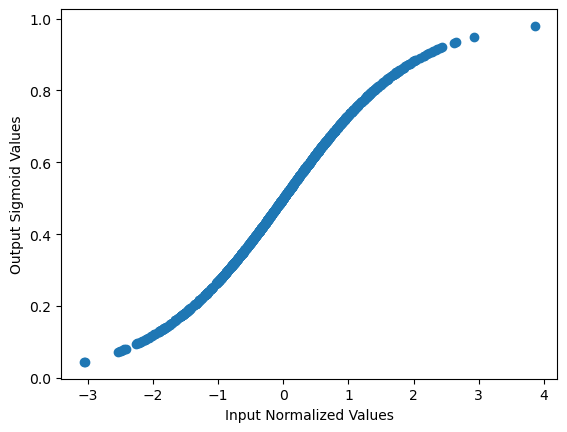

In [13]:
import matplotlib.pyplot as plt

normal_vals = np.random.normal(0, 1, 1000)
sig_vals = 1 / (1 + np.exp(-normal_vals))

plt.scatter(normal_vals, sig_vals)
plt.xlabel('Input Normalized Values')
plt.ylabel('Output Sigmoid Values')

In [14]:
simulation_steps.extend([
    {
        'type': 'StandardScaler',
        'alias': 'ENSG00000267443_scaled',
        'input_alias': 'ENSG00000267443_effect_sum'
	},
    {
        'type': 'Sigmoid',
        'alias': 'ENSG00000267443_damped_effect',
        'input_alias': 'ENSG00000267443_scaled',
    }
])

For the promoter, we'll have the variant reduce the gene's value by around 80%. We will draw the actual multiplier from a normal distribution centered at 0.8 with a small standard deviation. This uncertainty in the effect value of a variant could model something like an effect also influenced by the environment.

To implement this, we'll have nodes to:

- Draw a promoter effect value from the distribution
- Compute the product of (transcript variants effect) x (promoter effect)
- A conditional statement to use the product if the promoter variant is present or otherwise use the original value

In [15]:
simulation_steps.extend([
    {
        'type': 'Distribution',
        'alias': 'ENSG00000267443_promoter_multiplier',
        'input_match_size': 'ENSG00000267443_damped_effect',
        'dist_name': 'normal',
        'dist_kwargs': {
            'loc': 0.8,
            'scale': 0.025
        }
    },
    {
        'type': 'Product',
        'alias': 'ENSG00000267443_effect_with_promoter',
        'input_aliases': [
            'ENSG00000267443_damped_effect',
            'ENSG00000267443_promoter_multiplier'
        ]
    },
    {
        'type': 'IfElse',
        'alias': 'ENSG00000267443_haplotype_values',
        'input_cond_vals': 'ENSG00000267443_promoter',
        'input_if_vals': 'ENSG00000267443_effect_with_promoter',
        'input_else_vals': 'ENSG00000267443_damped_effect'
    }
])

Finally, we'll combine the haplotype values into a single value representing something like gene function. We'll add more non-linearity by using the geometric mean of the two haplotype values.

In [16]:
simulation_steps.extend([
    {
        'type': 'MeanCombine',
        'alias': 'ENSG00000267443',
        'input_alias': 'ENSG00000267443_haplotype_values',
        'mean_type': 'geometric'
	}
])

### CYP4F12: Rare and common variant effects

For this gene 40 relatively common and 40 relatively rare variants will be selected. Both types of variants will draw beta values from a zero-centered normal distribution, but the rare variants' distribution will have a larger variance. A ReLU with a threshold of 0 and negative slope of -1 will be used to make all rare variant effects poitive. The sum of these effects will represent some value for each haplotype.

We'll combine the haplotypes with a weighted average between an mean and dominance relationship. We will use both the `MaxCombine` and `MeanCombine` nodes, then compute the weighted average between their outputs.

CYP4F12


/Users/ross/miniforge3/envs/pheno_sim/lib/python3.10/site-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/Users/ross/miniforge3/envs/pheno_sim/lib/python3.10/site-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),


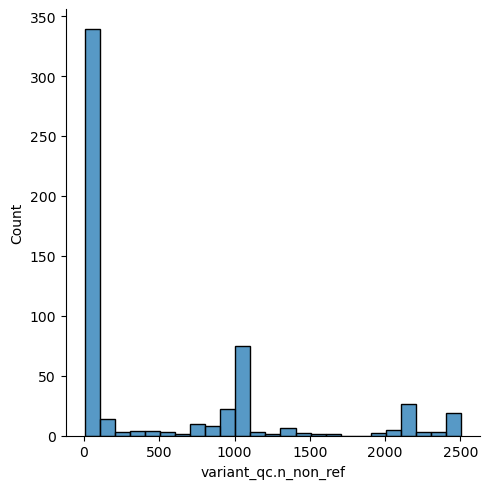

In [17]:
# Get variants for second gene
gene_idx =1
print(genes_to_use[gene_idx])
gene_vars = variant_info.get_variants_in_interval(
    genes[genes['name2'] == genes_to_use[gene_idx]].interval
)[var_info_cols]
gene_vars = gene_vars.drop_duplicates(subset=['locus'], keep=False)[
    (gene_vars['variant_qc.n_non_ref'] >= 5)
    & (~gene_vars['info.MULTI_ALLELIC'])
]
sns.displot(
    gene_vars['variant_qc.n_non_ref'],
    binwidth=100,
)

In [18]:
# Select rare and common vars
rng = np.random.RandomState(147)

common_vars = gene_vars[gene_vars['variant_qc.n_non_ref'] > 250].locus.apply(
    lambda x: x.position
).astype(int)
common_vars = rng.choice(common_vars, size=40, replace=False).tolist()

rare_vars = gene_vars[gene_vars['variant_qc.n_non_ref'] < 250].locus.apply(
    lambda x: x.position
).astype(int)
rare_vars = rng.choice(rare_vars, size=40, replace=False).tolist()

In [19]:
# Add input nodes
input_nodes.append({
    'alias': 'CYP4F12_common',
    'type': 'SNP',
    'chr': '19',
    'pos': common_vars
})

input_nodes.append({
    'alias': 'CYP4F12_rare',
    'type': 'SNP',
    'chr': '19',
    'pos': rare_vars
})

#### Simulation steps

First we'll add operator nodes for the weights and the modification to the rare variants' weights with the ReLU operator to make them all positive.

In [20]:
simulation_steps.extend([
    {
        'type': 'RandomConstant',
        'alias': 'CYP4F12_common_betas',
        'input_match_size': 'CYP4F12_common',
        'dist_name': 'normal',
        'dist_kwargs': {
            'loc': 0.0,
            'scale': 0.2
        },
        'by_feat': True
	},
    {
        'type': 'RandomConstant',
        'alias': 'CYP4F12_rare_betas',
        'input_match_size': 'CYP4F12_rare',
        'dist_name': 'normal',
        'dist_kwargs': {
            'loc': 0.0,
            'scale': 0.4
        },
        'by_feat': True
	},
    {
        'type': 'ReLU',
        'alias': 'CYP4F12_rare_betas_pos',
        'input_alias': 'CYP4F12_rare_betas',
        'neg_slope': -1.0,
    }
])

We'll take the sum of these effects together to get values for each haplotype. We will also damp extremely high and low effects with `Tanh`, modeling for example the limits of how much gene function can be improved or degraded by the variants.

In [21]:
simulation_steps.extend([
    {
		'type': 'Product',
		'alias': 'CYP4F12_common_effects',
		'input_aliases': ['CYP4F12_common_betas', 'CYP4F12_common']
	},
    {
		'type': 'Product',
		'alias': 'CYP4F12_rare_effects',
		'input_aliases': ['CYP4F12_rare_betas_pos', 'CYP4F12_rare']
	},
    {
        'type': 'Concatenate',
        'alias': 'CYP4F12_effects',
        'input_aliases': ['CYP4F12_common_effects', 'CYP4F12_rare_effects']
	},
    {
        'type': 'SumReduce',
        'alias': 'CYP4F12_hap_val',
		'input_alias': 'CYP4F12_effects'
	},
    {
        'type': 'Tanh',
        'alias': 'CYP4F12_hap_val_damped',
        'input_alias': 'CYP4F12_hap_val'
	}
])

And then compute the weighted average between dominace and additive effects. We'll do 80% dominance and 20% additive effects.

In [22]:
simulation_steps.extend([
    {
        'type': 'MaxCombine',
        'alias': 'CYP4F12_max',
        'input_alias': 'CYP4F12_hap_val_damped'
	},
    {
        'type': 'MeanCombine',
        'alias': 'CYP4F12_mean',
        'input_alias': 'CYP4F12_hap_val_damped'
	},
    {
        'type': 'Concatenate',
        'alias': 'CYP4F12_comb_vals',
        'input_aliases': ['CYP4F12_max', 'CYP4F12_mean']
	},
    {
        'type': 'Constant',
        'alias': 'CYP4F12_comb_weights',
        'constant': [0.8, 0.2],
        'input_match_size': 'CYP4F12_comb_vals'
	},
    {
        'type': 'Product',
        'alias': 'CYP4F12_comb_vals_weighted',
        'input_aliases': ['CYP4F12_comb_vals', 'CYP4F12_comb_weights']
	},
    {
        'type': 'MeanReduce',
        'alias': 'CYP4F12',
        'input_alias': 'CYP4F12_comb_vals_weighted'
	}
])    

### EID2B: If any

EID2B has 13 variants in the dataset. Seven of these have a minor allele count of at least 100. These variants will be multiplied by betas drawn from a all-positive distribution, and their products will be summed into one value.

We will consider the other six variants deleterious. Each will draw a multiplier from a distribution centered at 0.2. If any of the deleterious variants is present, the sum of the non-deleterious variants will be multiplied smallest multipier for a present deleterious variant.

In [23]:
# Get variants for third gene
gene_idx = 2
print(genes_to_use[gene_idx])
gene_vars = variant_info.get_variants_in_interval(
    genes[genes['name2'] == genes_to_use[gene_idx]].interval
)[var_info_cols]
gene_vars = gene_vars.drop_duplicates(subset=['locus'], keep=False)[
    (gene_vars['variant_qc.n_non_ref'] >= 5)
    & (~gene_vars['info.MULTI_ALLELIC'])
].reset_index(drop=True)

gene_vars

EID2B


,locus,alleles,info.AC,variant_qc.AF,variant_qc.n_non_ref,info.MULTI_ALLELIC,info.EAS_AF,info.EUR_AF,info.AFR_AF,info.AMR_AF,info.SAS_AF
0,19:40021718,"[CA, C]",[1695],"[0.6615415335463258, 0.3384584664536741]",1399,False,[0.4742],[0.34],[0.2678],[0.3127],[0.3108]
1,19:40021759,"[T, G]",[1166],"[0.7671725239616614, 0.23282747603833867]",1013,False,[0.3423],[0.2664],[0.1498],[0.2478],[0.1871]
2,19:40021803,"[C, T]",[797],"[0.8408546325878594, 0.15914536741214058]",687,False,[0.0575],[0.2555],[0.0121],[0.1671],[0.3579]
3,19:40021816,"[T, C]",[39],"[0.9922124600638977, 0.007787539936102236]",38,False,[0.0],[0.0],[0.0272],[0.0043],[0.0]
4,19:40021823,"[C, CT]",[1174],"[0.7655750798722045, 0.23442492012779553]",1023,False,[0.3413],[0.2654],[0.1581],[0.2464],[0.1871]
5,19:40021880,"[C, G]",[461],"[0.9079472843450479, 0.09205271565495207]",433,False,[0.1319],[0.0736],[0.0938],[0.0634],[0.0879]
6,19:40022489,"[A, G]",[31],"[0.9938099041533547, 0.006190095846645367]",31,False,[0.0],[0.0],[0.0008],[0.0],[0.0307]
7,19:40022530,"[G, T]",[7],"[0.9986022364217252, 0.0013977635782747603]",7,False,[0.0],[0.0],[0.0],[0.0],[0.0072]
8,19:40022659,"[G, A]",[6],"[0.9988019169329073, 0.0011980830670926517]",6,False,[0.0],[0.0],[0.0045],[0.0],[0.0]
9,19:40022949,"[C, T]",[5],"[0.9990015974440895, 0.000998402555910543]",5,False,[0.0],[0.002],[0.0],[0.0043],[0.0]


In [24]:
# Add input nodes
input_nodes.append({
    'alias': 'EID2B_common',
    'type': 'SNP',
    'chr': '19',
    'pos': gene_vars[gene_vars['variant_qc.n_non_ref'] > 100].locus.apply(
        lambda x: x.position
    ).astype(int).tolist()
})

input_nodes.append({
    'alias': 'EID2B_deleterious',
    'type': 'SNP',
    'chr': '19',
    'pos': gene_vars[gene_vars['variant_qc.n_non_ref'] < 100].locus.apply(
        lambda x: x.position
    ).astype(int).tolist()
})

#### Simulation steps

First we can handle the common variants to get the sum of their effects. Since there are so few common variants, we'll add some noise as well with the `GaussianNoise` node.

In [25]:
simulation_steps.extend([
    {
        'type': 'RandomConstant',
        'alias': 'EID2B_common_betas',
        'input_match_size': 'EID2B_common',
        'dist_name': 'uniform',
        'dist_kwargs': {
            'low': 0.01,
            'high': 0.25
        },
        'by_feat': True
	},
    {
        'type': 'Product',
        'alias': 'EID2B_common_effects',
        'input_aliases': ['EID2B_common_betas', 'EID2B_common']
    },
    {
        'type': 'SumReduce',
        'alias': 'EID2B_common_effects_sum',
        'input_alias': 'EID2B_common_effects',
    },
    {
        'type': 'GaussianNoise',
        'alias': 'EID2B_common_effects_sum_w_noise_unbounded',
        'input_alias': 'EID2B_common_effects_sum',
        'noise_std': 0.025,
    },
    {
        'type': 'Clip',
        'alias': 'EID2B_common_effects_sum_w_noise',
        'input_alias': 'EID2B_common_effects_sum_w_noise_unbounded',
        'min_val': 0,
    }
])

Then the rare variants to get a multiplier and scaled value.

In [26]:
simulation_steps.extend([
    {
        'type': 'RandomConstant',
        'alias': 'EID2B_deleterious_multiplier',
        'input_match_size': 'EID2B_deleterious',
        'dist_name': 'normal',
        'dist_kwargs': {
            'loc': 0.3,
            'scale': 0.05
        },
        'by_feat': True
	},
    {
        'type': 'Constant',
        'alias': 'constant_1',
        'input_match_size': 'EID2B_deleterious',
        'constant': 1.0
    },
    {
        'type': 'IfElse',
        'alias': 'EID2B_multiplier_by_variant',
        'input_cond_vals': 'EID2B_deleterious',
        'input_if_vals': 'EID2B_deleterious_multiplier',
        'input_else_vals': 'constant_1'
    },
    {
        'type': 'MinReduce',
        'alias': 'EID2B_deleterious_multiplier',
        'input_alias': 'EID2B_multiplier_by_variant'
    },
    {
        'type': 'Product',
        'alias': 'EID2B_hap_val',
        'input_aliases': [
            'EID2B_deleterious_multiplier', 
            'EID2B_common_effects_sum_w_noise'
        ]
    }
])

We'll combine using the average value of the haplotypes.

In [27]:
simulation_steps.extend([
    {
        'type': 'MeanCombine',
        'alias': 'EID2B',
        'input_alias': 'EID2B_hap_val'
	}
])

## Test inputs and cis effects

To test the input nodes and the implementation of the cis effects, we can run the simulation to the point of the gene-level values.

In [28]:
from pprint import pprint

import pandas as pd

from pheno_sim import PhenoSimulation

sim_config['input'][0]['input_nodes'] = input_nodes

test_config = {
    'input': sim_config['input'],
    'simulation_steps': copy.deepcopy(simulation_steps)
}

sim = PhenoSimulation(test_config)

pprint(test_config)

{'input': [{'file': '1000_genomes_data/ALL.chr19.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz',
            'file_format': 'vcf',
            'force_bgz': True,
            'input_nodes': [{'alias': 'ENSG00000267443_transcribed',
                             'chr': '19',
                             'pos': [397597,
                                     397680,
                                     397687,
                                     397765,
                                     397772,
                                     397776,
                                     397828,
                                     397854,
                                     397896,
                                     398145,
                                     398291,
                                     398339,
                                     398367,
                                     398414,
                                     398469,
                                 

In [29]:
input_vals = sim.run_input_step()

Loading input data...


2023-08-18 13:50:28.363 Hail: INFO: wrote matrix table with 132 rows and 2504 columns in 3 partitions to /tmp/persist_MatrixTableiHzPOUjAzS


In [30]:
simulated_vals = sim.run_simulation_steps(copy.deepcopy(input_vals))

In [31]:
gene_val_aliases = [
    'ENSG00000267443', 'CYP4F12', 'EID2B'
]

df_vals = dict()
for k in gene_val_aliases:
    vals = simulated_vals[k]
    if vals.ndim == 1:
        df_vals[k] = vals
    else:
        df_vals[k] = vals[0]

df = pd.DataFrame(df_vals)

df = df.melt(
    var_name='gene'
)

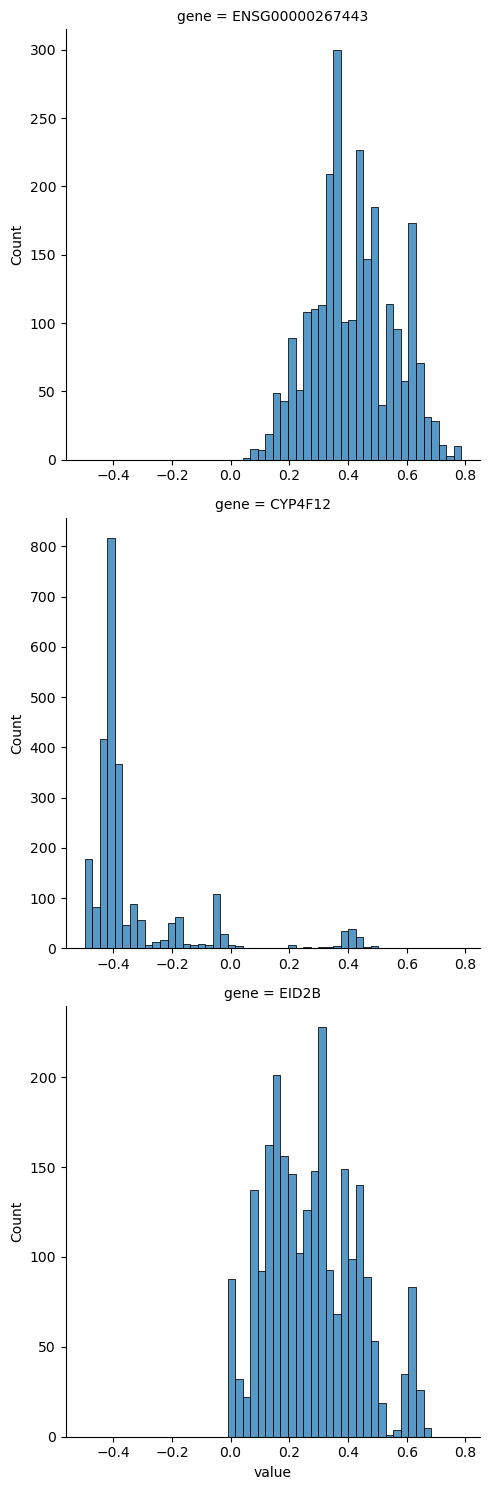

In [32]:
sns.displot(
    data=df,
    x='value',
    row='gene',
    bins=50,
    facet_kws={
        'sharex': False,
        'sharey': False,
    }
)

#### Visualizing effect of tanh in CYP4F12

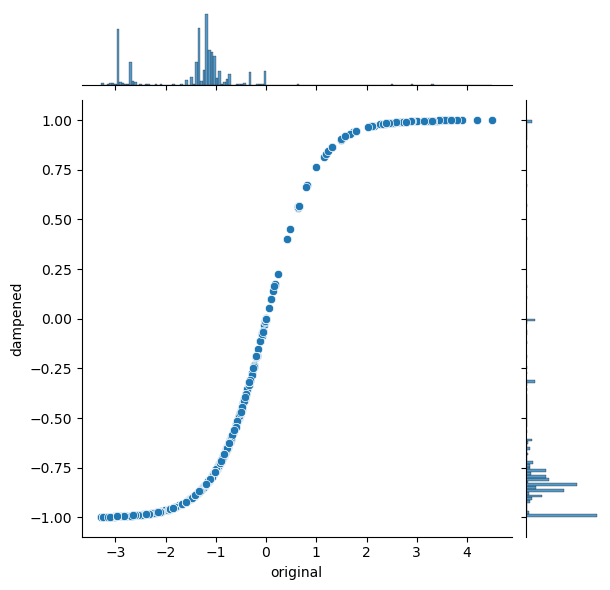

In [33]:
original_vals = np.array([
    simulated_vals['CYP4F12_hap_val'][0],
    simulated_vals['CYP4F12_hap_val'][1]
]).flatten()
dampened_vals = np.array([
    simulated_vals['CYP4F12_hap_val_damped'][0],
    simulated_vals['CYP4F12_hap_val_damped'][1]
]).flatten()

tanh_df = pd.DataFrame({
    'original': original_vals,
    'dampened': dampened_vals
})

sns.jointplot(
    data=tanh_df,
    x='original',
    y='dampened',
)

#### Visualizing masking by deleterious variants in EID2B

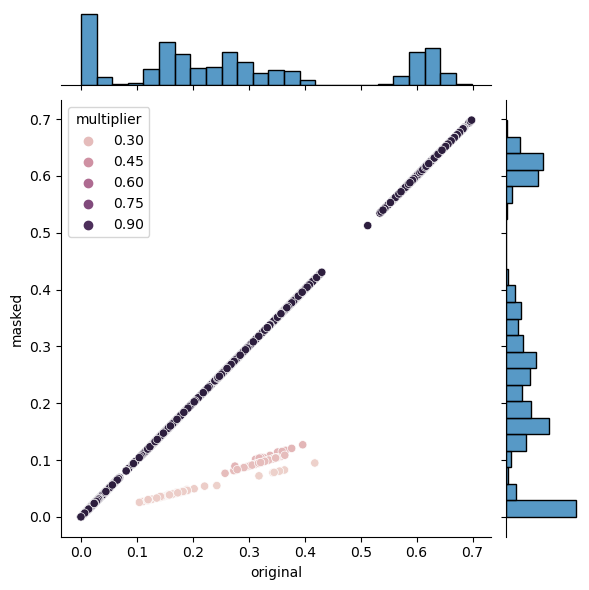

In [34]:
original_vals = np.array([
    simulated_vals['EID2B_common_effects_sum_w_noise'][0],
    simulated_vals['EID2B_common_effects_sum_w_noise'][1]
]).flatten()
masked_vals = np.array([
    simulated_vals['EID2B_hap_val'][0],
    simulated_vals['EID2B_hap_val'][1]
]).flatten()
multiplier_val = np.array([
    simulated_vals['EID2B_deleterious_multiplier'][0],
    simulated_vals['EID2B_deleterious_multiplier'][1]
]).flatten()

tanh_df = pd.DataFrame({
    'original': original_vals,
    'masked': masked_vals,
    'multiplier': multiplier_val
})

sns.jointplot(
    data=tanh_df,
    x='original',
    y='masked',
    joint_kws={'hue': tanh_df['multiplier']},
)

### Evaluate heritability of gene level value

We can use the same utilities to compute to heritability of a phenotype to compute the broad and narrow-sense heritability of any other non-haplotype level value (i.e. must have been combined with some Combine operator).

In [35]:
from pheno_sim.heritability_estimation import (
    narrow_sense_heritability,
    broad_sense_heritability
)

confidence_level = 0.99
narrow_kwargs = {
    'n_pheno_per_geno': 25
}
broad_kwargs = {
    'n_pheno_per_geno': 500,
}

In [36]:
pheno_alias = 'ENSG00000267443'
ENSG00000267443_broad = broad_sense_heritability(
    sim,
    input_vals=input_vals,
    confidence_level=confidence_level,
    phenotype_alias=pheno_alias,
    **broad_kwargs
)
ENSG00000267443_broad

100%|██████████| 10/10 [02:46<00:00, 16.69s/it]


{'H2': 0.997100657059512,
 'H2_ci_lower': 0.997096851193039,
 'H2_ci_upper': 0.9971033606498979}

In [37]:
ENSG00000267443_narrow = narrow_sense_heritability(
    sim,
    input_vals=input_vals,
    confidence_level=confidence_level,
    phenotype_alias=pheno_alias,
    **narrow_kwargs
)
ENSG00000267443_narrow

100%|██████████| 5/5 [00:27<00:00,  5.53s/it]


{'h2': -3.1135142623438136e+16,
 'h2_ci_lower': -1.209736310849073e+17,
 'h2_ci_upper': -7344643404208691.0}

In [38]:
pheno_alias = 'CYP4F12'
CYP4F12_broad = broad_sense_heritability(
    sim,
    input_vals=input_vals,
    confidence_level=confidence_level,
    phenotype_alias=pheno_alias,
    **broad_kwargs
)
CYP4F12_broad

100%|██████████| 10/10 [02:32<00:00, 15.26s/it]
/Users/ross/miniforge3/envs/pheno_sim/lib/python3.10/site-packages/scipy/stats/_resampling.py:144: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/Users/ross/miniforge3/envs/pheno_sim/lib/python3.10/site-packages/scipy/stats/_resampling.py:97: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  warnings.warn(DegenerateDataWarning(msg))


{'H2': 1.0, 'H2_ci_lower': nan, 'H2_ci_upper': nan}

In [39]:
CYP4F12_narrow = narrow_sense_heritability(
    sim,
    input_vals=input_vals,
    confidence_level=confidence_level,
    phenotype_alias=pheno_alias,
    **narrow_kwargs
)
CYP4F12_narrow

100%|██████████| 5/5 [00:25<00:00,  5.13s/it]


{'h2': -3.019938930308092e+17,
 'h2_ci_lower': -7.166274854209423e+17,
 'h2_ci_upper': -6.039877911886478e+16}

In [40]:
pheno_alias = 'EID2B'
EID2B_broad = broad_sense_heritability(
    sim,
    input_vals=input_vals,
    confidence_level=confidence_level,
    phenotype_alias=pheno_alias,
    **broad_kwargs
)
EID2B_broad

100%|██████████| 10/10 [02:27<00:00, 14.78s/it]


{'H2': 0.9886784988464632,
 'H2_ci_lower': 0.9886635896446635,
 'H2_ci_upper': 0.9886911043506214}

In [41]:
EID2B_narrow = narrow_sense_heritability(
    sim,
    input_vals=input_vals,
    confidence_level=confidence_level,
    phenotype_alias=pheno_alias,
    **narrow_kwargs
)
EID2B_narrow

100%|██████████| 5/5 [00:25<00:00,  5.11s/it]


{'h2': -5.948974144983215e+17,
 'h2_ci_lower': -2.0473370964966436e+18,
 'h2_ci_upper': -7.70272884812921e+16}

## Step 3: Defining trans-acting effects and final phenotype

Our final phenotype will be a function of these gene-level values. It will be the sum of three terms:

#### CYP4F12

The gene level value for CYP4F12.

#### ReLU(EID2B) * ENSG00000267443

We'll apply a ReLU function with  a threshold of 0.2, a negative slope of 1.0, and a positive slope of 1.2 to the EID2B value before multiplying it by the ENSG00000267443 value. This model a piecewise relationship between the expression of EID2B and the impact of ENSG00000267443 on the phenotype.

In [42]:
def relu(x, threshold=0, pos_slope=1, neg_slope=0):
	return np.where(x > threshold, x * pos_slope, x * neg_slope)

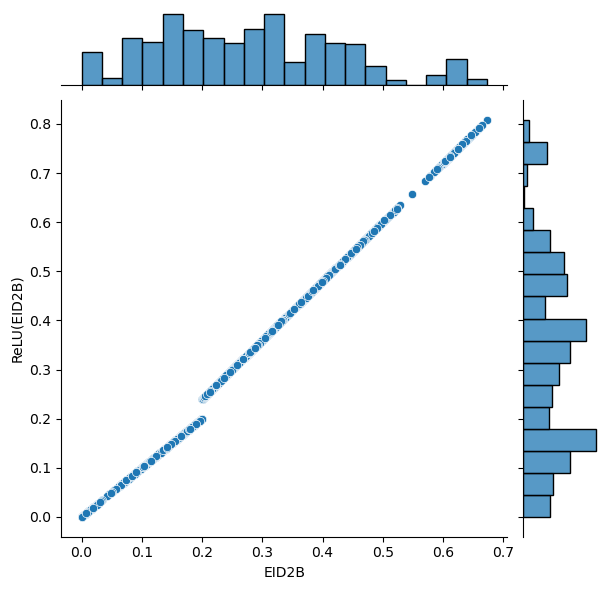

In [43]:
sns.jointplot(
    data=simulated_vals,
    x='EID2B',
    y=relu(
        simulated_vals['EID2B'],
        threshold=0.2,
        pos_slope=1.2,
        neg_slope=1.0
    ),
)

plt.xlabel('EID2B')
plt.ylabel('ReLU(EID2B)')

plt.show()

In [44]:
simulation_steps.extend([
    {
        'type': 'ReLU',
        'alias': 'ReLU_EID2B',
        'input_alias': 'EID2B',
        'threshold': 0.2,
        'neg_slope': 1.0,
        'pos_slope': 1.2,
	},
    {
        'type': 'Product',
        'alias': 'EID2B_ENSG00000267443_interaction',
        'input_aliases': ['ReLU_EID2B', 'ENSG00000267443'],
    }
])

#### EID2B modified by relative abundances of ENSG00000267443 and CYP4F12

Here we'll use a `SoftMax` to model the effect of the relative abundances of ENSG00000267443 and CYP4F12 on the impact of EID2B on the final phenotype. We will model the situation where EID2B contributes more to the phenotype the more balanced the standardized values for ENSG00000267443 and CYP4F12 are.

The final equation will look like:

$$ \text{Contribution to phenotype} = \text{EID2B} \times \text{Min}( \text{SoftMax}(\text{Standardized ENSG00000267443}, \text{Standardized CYP4F12})) $$

In [45]:
simulation_steps.extend([
    {
        'type': 'StandardScaler',
        'alias': 'zscore_ENSG00000267443',
        'input_alias': 'ENSG00000267443',
	},
    {
        'type': 'StandardScaler',
        'alias': 'zscore_CYP4F12',
        'input_alias': 'CYP4F12',
	},
    {
        'type': 'Concatenate',
        'alias': 'concat_zscores',
        'input_aliases': ['zscore_ENSG00000267443', 'zscore_CYP4F12'],
	},
    {
        'type': 'Softmax',
		'alias': 'softmax_zscores',
		'input_alias': 'concat_zscores',
	},
    {
        'type': 'MinReduce',
		'alias': 'min_softmax',
		'input_alias': 'softmax_zscores',
	},
    {
        'type': 'Product',
		'alias': 'EID2B_relative_abundance_interaction',
		'input_aliases': ['min_softmax', 'EID2B'],
	},
])        

#### Final phenotype

These terms are them summed into the final phenotype value.

In [46]:
simulation_steps.extend([
    {
        'type': 'Sum',
        'alias': 'phenotype',
        'input_aliases': [
            'CYP4F12',
            'EID2B_ENSG00000267443_interaction',
            'EID2B_relative_abundance_interaction'
        ]
	}
])

## Step 4: Testing full simulation

In [47]:
sim_config['input'][0]['input_nodes'] = input_nodes

final_config = {
    'input': sim_config['input'],
    'simulation_steps': copy.deepcopy(simulation_steps)
}

sim = PhenoSimulation(copy.deepcopy(final_config))

pprint(final_config)

{'input': [{'file': '1000_genomes_data/ALL.chr19.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz',
            'file_format': 'vcf',
            'force_bgz': True,
            'input_nodes': [{'alias': 'ENSG00000267443_transcribed',
                             'chr': '19',
                             'pos': [397597,
                                     397680,
                                     397687,
                                     397765,
                                     397772,
                                     397776,
                                     397828,
                                     397854,
                                     397896,
                                     398145,
                                     398291,
                                     398339,
                                     398367,
                                     398414,
                                     398469,
                                 

In [48]:
simulated_vals = sim.run_simulation_steps(copy.deepcopy(input_vals))

In [49]:
val_aliases = [
    'ENSG00000267443', 'CYP4F12', 'EID2B', 'phenotype'
]

df_vals = dict()
for k in val_aliases:
    vals = simulated_vals[k]
    if vals.ndim == 1:
        df_vals[k] = vals
    else:
        df_vals[k] = vals[0]

df = pd.DataFrame(df_vals)

melted_df = df.melt(
    var_name='Gene/Phenotype'
)

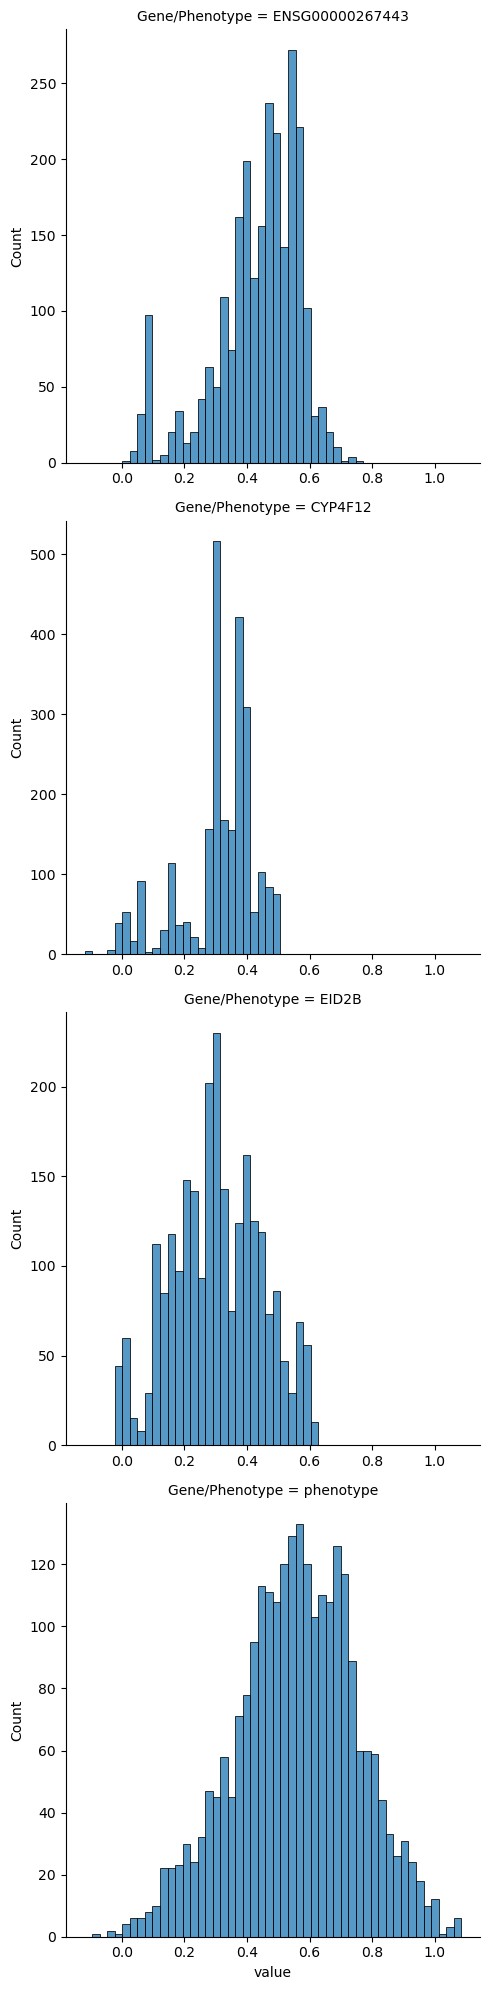

In [50]:
sns.displot(
    data=melted_df,
    x='value',
    row='Gene/Phenotype',
    bins=50,
    facet_kws={
        'sharex': False,
        'sharey': False,
    }
)

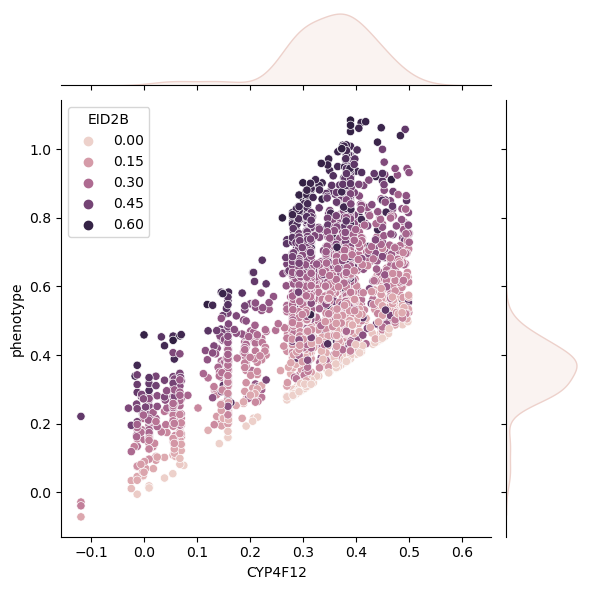

In [51]:
sns.jointplot(
    data=df,
    x='CYP4F12',
    y='phenotype',
    hue='EID2B'
)

### Evaluate heritability of phenotype

In [52]:
pheno_alias = 'phenotype'
pheno_broad = broad_sense_heritability(
    sim,
    input_vals=input_vals,
    confidence_level=confidence_level,
    phenotype_alias=pheno_alias,
    **broad_kwargs
)
pheno_broad

100%|██████████| 10/10 [02:30<00:00, 15.04s/it]


{'H2': 0.9941081233709352,
 'H2_ci_lower': 0.994099061979513,
 'H2_ci_upper': 0.9941150870261645}

In [53]:
pheno_narrow = narrow_sense_heritability(
    sim,
    input_vals=input_vals,
    confidence_level=confidence_level,
    phenotype_alias=pheno_alias,
    **narrow_kwargs
)
pheno_narrow

100%|██████████| 5/5 [00:26<00:00,  5.21s/it]


{'h2': -3.159004962159839e+17,
 'h2_ci_lower': -8.256324555611132e+17,
 'h2_ci_upper': -6.2280676700509e+16}

### Save Config as JSON

In [54]:
import os
import json

with open(os.path.join('json_configs', 'complex_pheno_1.json'), 'w') as f:
    json.dump(final_config, f, indent=4)